In [1]:
%matplotlib inline

# Top level imports
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Location for training and validation images.
PATH = 'Images/data/'
os.listdir(PATH)

['.DS_Store', 'cifar-10-batches-py', 'train', 'cifar-10-python.tar.gz', 'val']

In [3]:
# Pytorch imports
import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.models as mdl
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets

In [4]:
# Location for the training and validation sets
traindir = os.path.join(PATH, 'train')
valdir = os.path.join(PATH, 'val')

# Transforms the images into a nice format.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
resize = transforms.RandomResizedCrop(448)

# Transformation object, converts to a tensor then normalizes.
trans = transforms.Compose([transforms.ToTensor(), normalize])

# Image folders
trainfolder = datasets.ImageFolder(traindir, transform=trans)
valfolder = datasets.ImageFolder(valdir, transform=trans)

# Loader objects for loading the data, batches of 5.
trainloader = torch.utils.data.DataLoader(trainfolder, batch_size=5, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valfolder, batch_size=5, shuffle=False, num_workers=2)



In [5]:
def train(loader, net, crit, opt):
    net.train()
    
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        # Get the input with their true labels
        inputs, labels = data

        # Zeros the optimzer
        opt.zero_grad()

        # Get the predicted labels and find the loss by comparing
        outputs = net(inputs)
        loss = crit(outputs, labels)
        
        # Propagate the loss backwards
        loss.backward()
        opt.step()

        # Prints every 5 batches (Batch size currently 5, so every 25 images)
        running_loss += loss.item()
        if i % 5 == 4:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0
    
    

In [6]:
# Sets up the network
net = mdl.resnet34(True) # True = pretrained on ImageNet
net.avgpool = nn.AdaptiveAvgPool2d(1)
net.fc = torch.nn.Linear(512,2)

# Sets up required network functions
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


In [7]:
for epoch in range(2):
    train(trainloader, net, criterion, optimizer)

print('Finished Training')

[1,     5] loss: 0.464
[1,    10] loss: 0.696
[1,    15] loss: 0.405
[1,    20] loss: 0.030
[1,    25] loss: 0.001
[1,    30] loss: 0.153
[1,    35] loss: 3.185
[1,    40] loss: 0.509
[2,     5] loss: 0.027
[2,    10] loss: 0.149
[2,    15] loss: 1.634
[2,    20] loss: 0.301
[2,    25] loss: 0.797
[2,    30] loss: 0.033
[2,    35] loss: 0.069
[2,    40] loss: 1.255
Finished Training


In [8]:
def unnormalize(img):
    # Transform does x_new = (x - mean)/sigma
    # Reverse the math x = (x_new + mean/sigma)/(1/sigma)
    # So mean_new = -mean/sigma
    # sigma_new = 1/sigma
    inv = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],std=[1/0.229, 1/0.224, 1/0.225])
    
    return inv(img)
    

The following cells are for validation.

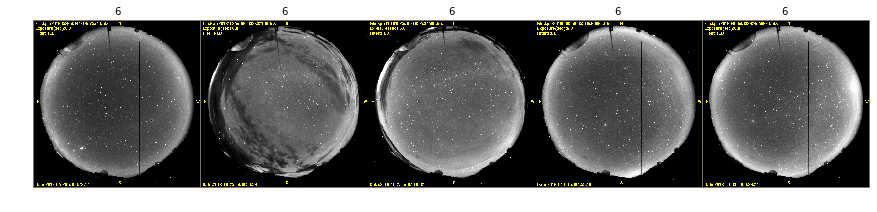

In [9]:
images, labels = iter(trainloader).next()
img = torchvision.utils.make_grid(images)

# Unnormalize and convert to a numpy array for display
img = unnormalize(img)
img = img.numpy()

# Transpose the array to (dim1, dim2, dim0)
img2 = np.transpose(img, (1, 2, 0))

# Display, make it bigger, turn off the axes
fig, ax = plt.subplots()
ax.set_axis_off()
fig.set_size_inches(15, 7)
plt.imshow(img2)

classes = ['0.3', '6']

for j in range(5):
    label = classes[labels[j]]
    x = (500 / 2) + (j * 512)
    ax.text(x, -15, label)

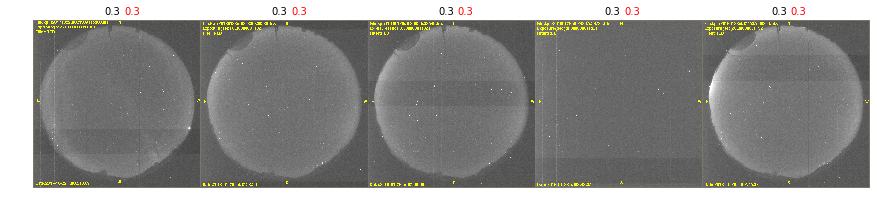

In [14]:
images, labels = iter(valloader).next()

# Display the images, with their true labels
img = torchvision.utils.make_grid(images)

# Unnormalize and convert to a numpy array for display
img = unnormalize(img)
img = img.numpy()

# Transpose the array to (dim1, dim2, dim0)
img2 = np.transpose(img, (1, 2, 0))

# Display, make it bigger, turn off the axes
fig, ax = plt.subplots()
ax.set_axis_off()
fig.set_size_inches(15, 7)
plt.imshow(img2)

# Gap between true and predicted labels
gap = 60

for j in range(5):
    label = classes[labels[j]]
    x = (500 / 2) + (j * 512) - (gap / 2)
    ax.text(x, -15, label)

#net.eval()

# Get the network's predicted labels
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Puts the predicted labels in red next to the true labels
for j in range(5):
    label = classes[labels[j]]
    x = (500 / 2) + (j * 512) + (gap / 2)
    ax.text(x, -15, label, color='r')

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        # The true labels and image data
        images, labels = data
        
        # Gets the predicted labels
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Adds to the total the number of labels here (should be equal to batch size)
        total = total + labels.size(0)
        
        # If the predicted label is the same as the true label increment correct by 1
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print('Total images: ' + str(total) 
      pri+ ' test images: '  + str(accuracy) + '%')

Accuracy of the network on the 50 test images: 64.0%
